In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.0 MB/s eta 0:00:00


In [ ]:
pip install imageio plotly

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
import plotly.express as px
#import gif
import imageio.v3 as iio

In [ ]:
data = pd.read_csv('/content/metro_station_peak_hour_data (2).csv')
data.head()

,Time Interval,Day,SpecialEvent,Weather,People Count
0,01-01-2024 00:00,Monday,False,Rainy,10
1,01-01-2024 00:10,Monday,False,Rainy,14
2,01-01-2024 00:20,Monday,False,Cloudy,11
3,01-01-2024 00:30,Monday,False,Rainy,10
4,01-01-2024 00:40,Monday,False,Sunny,10


In [ ]:
# One-Hot Encoding for categorical variables
ohe = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = ohe.fit_transform(data[['Day', 'SpecialEvent', 'Weather']])

In [ ]:
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(['Day', 'SpecialEvent', 'Weather']))
data = pd.concat([data, encoded_df], axis=1)
data.drop(['Day', 'SpecialEvent', 'Weather'], axis=1, inplace=True)

In [ ]:
data.columns

Index(['Time Interval', 'People Count', 'Day_Monday', 'Day_Saturday',
       'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday',
       'SpecialEvent_True', 'Weather_Rainy', 'Weather_Sunny'],
      dtype='object')

In [ ]:
# Set the time as the index
data.set_index('Time Interval', inplace=True)
# Specify the correct format for day-first dates
data.index = pd.to_datetime(data.index, format='%d-%m-%Y %H:%M')

In [ ]:
# Split the data into features and target
X = data.drop('People Count', axis=1)
y = data['People Count']

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# **VISUALIZATIONS**

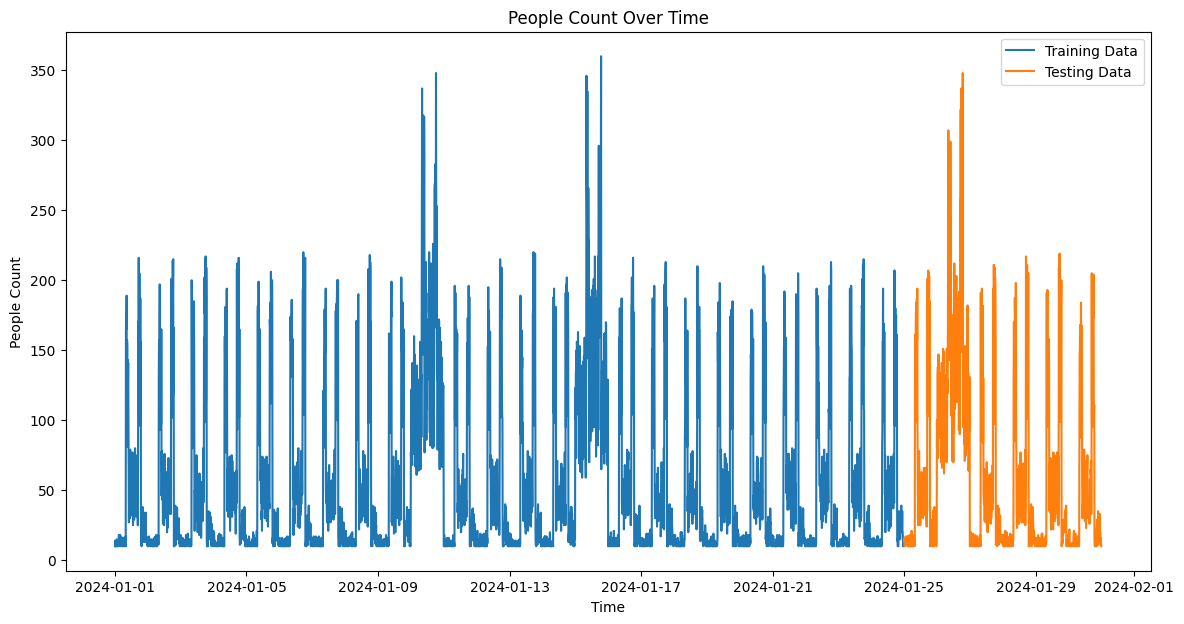

In [ ]:
# Plot the time series of people count
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Testing Data')
plt.title('People Count Over Time')
plt.xlabel('Time')
plt.ylabel('People Count')
plt.legend()
plt.show()

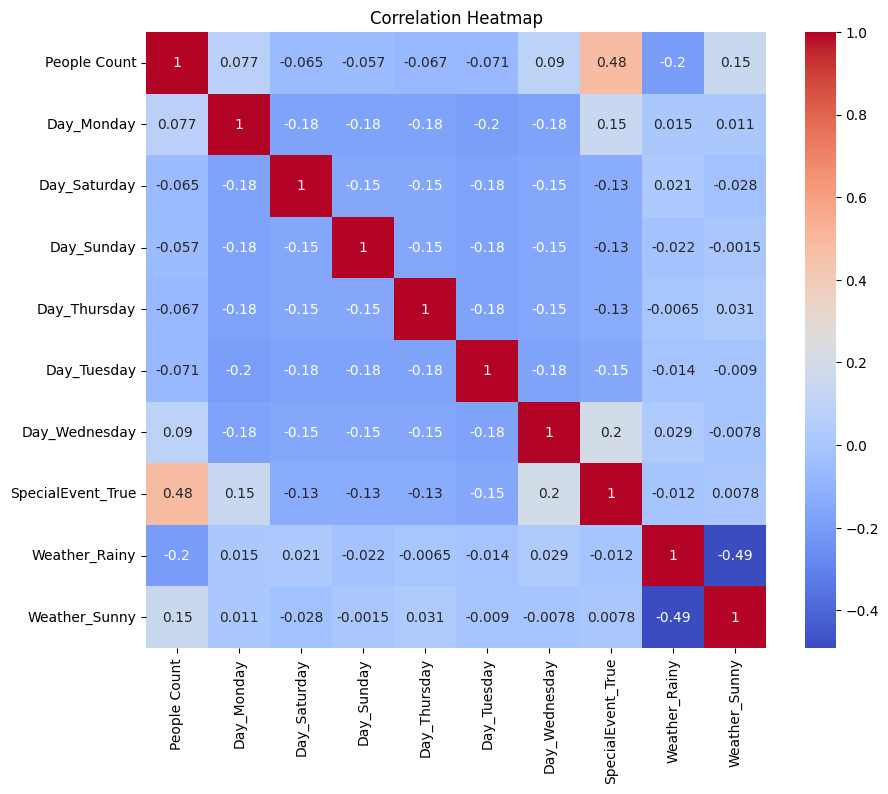

In [ ]:
# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print("Series is NOT stationary. Applying differencing...")
        return series.diff().dropna()
    else:
        print("Series is stationary.")
        return series

y_train = check_stationarity(y_train)

ADF Statistic: -8.166999356662554, p-value: 8.828242695009954e-13
Series is stationary.


# **SARIMAX MODEL**

In [ ]:
# Scale exogenous variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go

# Plot forecast
fig = plot_plotly(model, forecast)
fig.update_layout(
    title="Prophet Forecast vs. Actual Test Data",
    xaxis_title="Time",
    yaxis_title="People Count"
)

# Highlight peak hours (top 10% of predictions)
peak_threshold = forecast['yhat'].quantile(0.9)
peaks = forecast[forecast['yhat'] > peak_threshold]
fig.add_trace(
    go.Scatter(
        x=peaks['ds'],
        y=peaks['yhat'],
        mode='markers',
        marker=dict(color='red', size=8),
        name='Peak Hours'
    )
)

# Add actual test data to the plot
test_df = pd.DataFrame({'ds': y_test.index, 'y': y_test})
fig.add_trace(
    go.Scatter(
        x=test_df['ds'],
        y=test_df['y'],
        mode='lines',
        line=dict(color='green', dash='dot'),
        name='Actual Test Data'
    )
)

fig.show()

In [ ]:
import plotly.express as px

# Prepare data for heatmap
forecast['hour'] = forecast['ds'].dt.hour
forecast['date'] = forecast['ds'].dt.date
heatmap_data = forecast.pivot_table(index='date', columns='hour', values='yhat', aggfunc='mean')

# Interactive heatmap
fig = px.imshow(
    heatmap_data.T,
    labels=dict(x="Date", y="Hour of Day", color="People Count"),
    title="Peak Crowd Hours Heatmap (Predicted)",
    color_continuous_scale='viridis'
)
fig.update_xaxes(type='category')
fig.show()

<ipython-input-22-2dfe8e31dd4d>:32: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



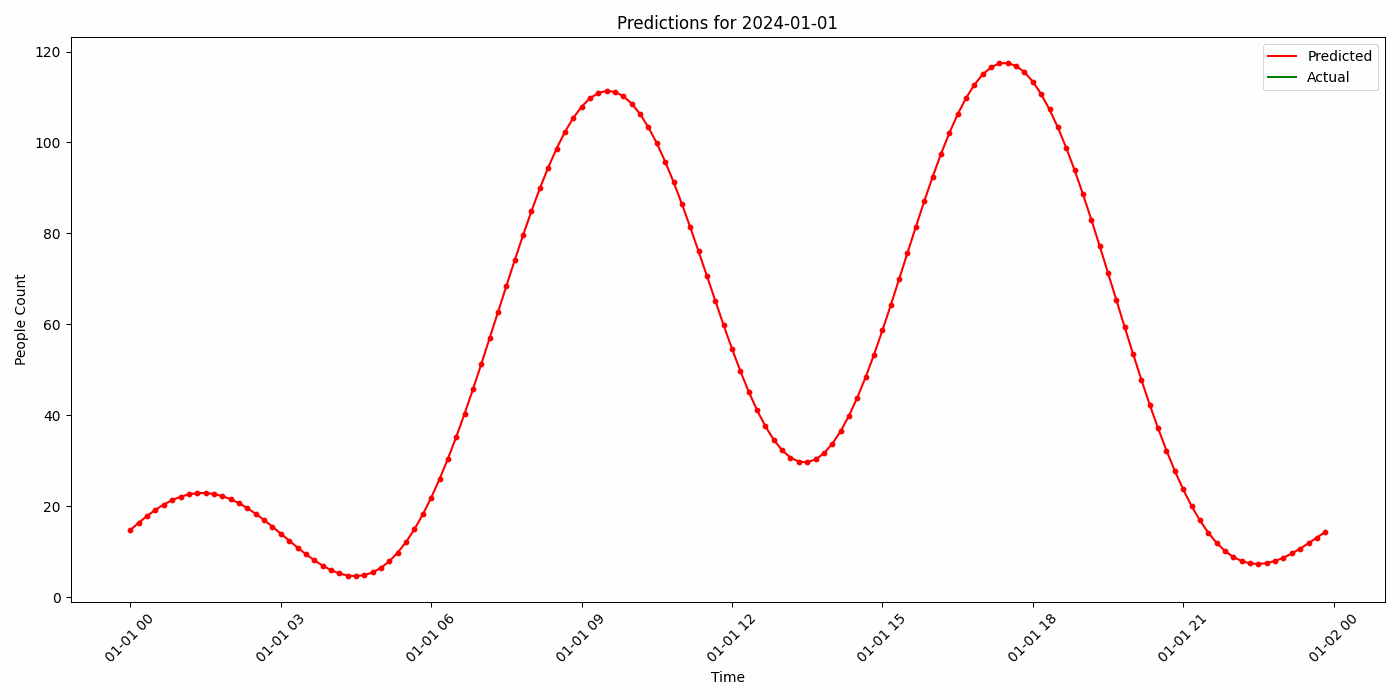

In [ ]:
import matplotlib.pyplot as plt
import imageio

# Create daily frames for GIF
dates = forecast['ds'].dt.date.unique()
frames = []

for date in dates:
    daily_data = forecast[forecast['ds'].dt.date == date]

    plt.figure(figsize=(14, 7))
    plt.plot(daily_data['ds'], daily_data['yhat'], label='Predicted', color='red')
    plt.scatter(daily_data['ds'], daily_data['yhat'], color='red', s=10)

    # Add actual data if available (for test period overlap)
    try:
        actual_daily = test_df[test_df['ds'].dt.date == date]
        plt.plot(actual_daily['ds'], actual_daily['y'], label='Actual', color='green')
    except:
        pass

    plt.title(f"Predictions for {date.strftime('%Y-%m-%d')}")
    plt.xlabel("Time")
    plt.ylabel("People Count")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save frame
    plt.savefig(f'frame_{date}.png')
    plt.close()
    frames.append(imageio.imread(f'frame_{date}.png'))

# Create GIF
imageio.mimsave('prophet_predictions.gif', frames, duration=1000)  # 1 second per frame

# Display in Colab
from IPython.display import Image
Image(filename='prophet_predictions.gif')

In [ ]:
from IPython.display import display

# Find top 3 peak hours per day
peak_hours = forecast.groupby(forecast['ds'].dt.date).apply(
    lambda x: x.nlargest(3, 'yhat')[['ds', 'yhat']]
).reset_index(drop=True)

# Format the table
peak_hours['Time'] = peak_hours['ds'].dt.strftime('%I:%M %p')
# Include 'date' as a column in peak_hours
peak_hours['date'] = peak_hours['ds'].dt.date
peak_table = peak_hours.pivot_table(
    index='date',
    values='Time',
    aggfunc=lambda x: ', '.join(x)
).rename(columns={'Time': 'Peak Hours'})

display(peak_table.style.set_caption("Daily Peak Hours (Predicted)"))

,Peak Hours
date,
2024-01-01,"05:30 PM, 05:20 PM, 05:40 PM"
2024-01-02,"05:30 PM, 05:20 PM, 05:40 PM"
2024-01-03,"05:30 PM, 05:20 PM, 05:40 PM"
2024-01-04,"05:30 PM, 05:20 PM, 05:40 PM"
2024-01-05,"05:30 PM, 05:20 PM, 05:40 PM"
2024-01-06,"05:30 PM, 05:20 PM, 09:30 AM"
2024-01-07,"05:30 PM, 05:40 PM, 05:20 PM"
2024-01-08,"05:30 PM, 05:20 PM, 05:40 PM"
2024-01-09,"05:30 PM, 05:40 PM, 05:20 PM"


In [ ]:
# Align test data with predictions
test_period = forecast[forecast['ds'].isin(test_df['ds'])]
mse = mean_squared_error(test_df['y'], test_period['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_df['y'], test_period['yhat'])

print(f"""
Performance Metrics:
- RMSE: {rmse:.2f}
- MAE: {mae:.2f}
""")


Performance Metrics:
- RMSE: 67.40
- MAE: 48.61



In [ ]:
from plotly.subplots import make_subplots

# Create dashboard
dashboard = make_subplots(
    rows=3, cols=1,
    specs=[[{"type": "scatter"}], [{"type": "heatmap"}], [{"type": "table"}]],
    subplot_titles=("Forecast vs. Actual", "Peak Hour Heatmap", "Daily Peak Hours")
)

# Add forecast plot
dashboard.add_trace(
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted'),
    row=1, col=1
)
dashboard.add_trace(
    go.Scatter(x=test_df['ds'], y=test_df['y'], name='Actual (Test)', line=dict(dash='dot')),
    row=1, col=1
)

# Add heatmap
dashboard.add_trace(
    go.Heatmap(
        z=heatmap_data.T.values,
        x=heatmap_data.index,
        y=heatmap_data.columns,
        colorscale='viridis'
    ),
    row=2, col=1
)

# Add peak hours table
dashboard.add_trace(
    go.Table(
        header=dict(values=["Date", "Peak Hours"]),
        cells=dict(values=[peak_table.index.astype(str), peak_table['Peak Hours']])
    ),
    row=3, col=1
)

dashboard.update_layout(height=1200, title_text="Metro Crowd Prediction Dashboard")
dashboard.show()